**ML ASSIGNMENT2 - Vaibhav Khare**

Vaibhav Khare - 2025ab05182@wilp.bits-pilani.ac.in

## **Ensemble Model - Random Forest on Portuguese banking institution**


***About Datset***

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

In [1]:
#Import Libraries
import os;
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Export Train, Test, Bank Details Dataset
bank_train =pd.read_csv('https://raw.githubusercontent.com/vaibhavkhare1/ML_ASSIGNMENT_COMPARISION_REPO/main/bank-full.csv');
bank_test =pd.read_csv('https://raw.githubusercontent.com/vaibhavkhare1/ML_ASSIGNMENT_COMPARISION_REPO/main/bank-test.csv')

In [3]:
#Handle Categorical features

categorical_cols = bank_train.select_dtypes(include='object').columns.tolist()
if 'y' in categorical_cols:
    categorical_cols.remove('y')

print(f"Identified categorical columns (excluding 'y'): {categorical_cols}")

Identified categorical columns (excluding 'y'): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']


In [4]:
#Apply One Hot Encoding to convert these categorical variables into a numerical format suitable for machine learning models

bank_train_encoded = pd.get_dummies(bank_train, columns=categorical_cols, drop_first=False)
bank_test_encoded = pd.get_dummies(bank_test, columns=categorical_cols, drop_first=False)

# Align columns between bank_train_encoded and bank_test_encoded
# Get all columns from the training set (bank_train_encoded)
aligned_columns = bank_train_encoded.columns.tolist()

# Reindex the test set to match the training set columns, filling missing with 0
bank_test_encoded = bank_test_encoded.reindex(columns=aligned_columns, fill_value=0)

print("Shape of bank_train_encoded:", bank_train_encoded.shape)
print("Shape of bank_test_encoded:", bank_test_encoded.shape)
print("First 5 rows of bank_train_encoded:")
print(bank_train_encoded.head())
print("\nFirst 5 rows of bank_test_encoded:")
print(bank_test_encoded.head())

Shape of bank_train_encoded: (45211, 52)
Shape of bank_test_encoded: (4521, 52)
First 5 rows of bank_train_encoded:
   age  balance  day  duration  campaign  pdays  previous   y  job_admin.  \
0   58     2143    5       261         1     -1         0  no       False   
1   44       29    5       151         1     -1         0  no       False   
2   33        2    5        76         1     -1         0  no       False   
3   47     1506    5        92         1     -1         0  no       False   
4   33        1    5       198         1     -1         0  no       False   

   job_blue-collar  ...  month_jun  month_mar  month_may  month_nov  \
0            False  ...      False      False       True      False   
1            False  ...      False      False       True      False   
2            False  ...      False      False       True      False   
3             True  ...      False      False       True      False   
4            False  ...      False      False       True      Fals

In [5]:
# Prepare Feature and Target Sets
X_train = bank_train_encoded.drop('y', axis=1)
y_train = bank_train_encoded['y']

X_test = bank_test_encoded.drop('y', axis=1)
y_test = bank_test_encoded['y']

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (45211, 51)
Shape of y_train: (45211,)
Shape of X_test: (4521, 51)
Shape of y_test: (4521,)


In [6]:
#Apply Log Tranformation to target
y_train = y_train.map({'yes': 1, 'no': 0})
y_test = y_test.map({'yes': 1, 'no': 0})

print("Value counts of y_train after transformation:")
print(y_train.value_counts())
print(
"\nValue counts of y_test after transformation:")
print(y_test.value_counts())

Value counts of y_train after transformation:
y
0    39922
1     5289
Name: count, dtype: int64

Value counts of y_test after transformation:
y
0    4000
1     521
Name: count, dtype: int64


In [7]:
# Helper Function

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score, confusion_matrix, classification_report

def evaluate_model(model, X_test, y_test, model_name, use_scaled=False):
    """Evaluate model and return metrics"""
    X_test_eval = X_test_scaled if use_scaled else X_test
    # Predictions
    y_pred = model.predict(X_test_eval)
    y_pred_proba = model.predict_proba(X_test_eval) if hasattr(model, 'predict_proba') else None
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    mcc = matthews_corrcoef(y_test, y_pred)
    if y_pred_proba is not None:
        # For binary classification, roc_auc_score expects y_true (1D) and y_score (probabilities of the positive class, 1D)
        auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    else:
        auc = 0.0
    cm = confusion_matrix(y_test, y_pred)
    return {
        'model_name': model_name,
        'accuracy': round(accuracy, 4),
        'auc': round(auc, 4),
        'precision': round(precision, 4),
        'recall': round(recall, 4),
        'f1': round(f1, 4),
        'mcc': round(mcc, 4),
        'confusion_matrix': cm
    }

In [8]:
# Initialize and Train Ensemble Model - Random Forest Classifier

# # Import Library for Ensemble Model - Random Forest Classifier and Standard Scalar
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Ensemble Model - Random Forest Classifier
ran_for_model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)

# Train the model
ran_for_model.fit(X_train, y_train)

#Append Log Results to
ran_for_results = evaluate_model(ran_for_model, X_test_scaled, y_test, "Ensemble Model - Random Forest Classifier", use_scaled=False) # Pass scaled X_test directly

print("Ensemble Model - Random Forest Classifier trained successfully.")

Ensemble Model - Random Forest Classifier trained successfully.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


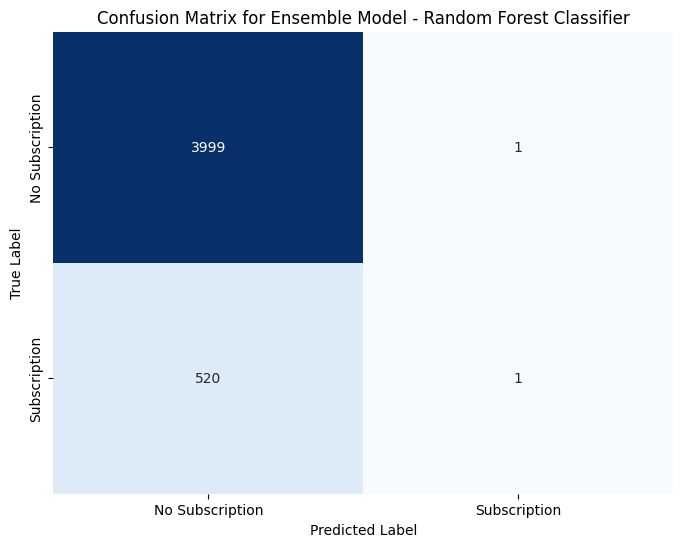

In [9]:
# Create Confusion Metrix

import matplotlib.pyplot as plt
import seaborn as sns

# Extract confusion matrix from ran_for_results
cm = ran_for_results['confusion_matrix']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Subscription', 'Subscription'],
            yticklabels=['No Subscription', 'Subscription'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Ensemble Model - Random Forest Classifier')
plt.show()

In [10]:
#Print Evaluation of Ensemble Model - Random Forest Classifier
print("Evaluation of Ensemble Model - Random Forest Classifier:\n")

print(f"Accuracy: {ran_for_results['accuracy']:.4f}")
print(f"AUC Score: {ran_for_results['auc']:.4f}")
print(f"Precision: {ran_for_results['precision']:.4f}")
print(f"Recall: {ran_for_results['recall']:.4f}")
print(f"F1 Score: {ran_for_results['f1']:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {ran_for_results['mcc']:.4f}")


Evaluation of Ensemble Model - Random Forest Classifier:

Accuracy: 0.8848
AUC Score: 0.6685
Precision: 0.8406
Recall: 0.8848
F1 Score: 0.8311
Matthews Correlation Coefficient (MCC): 0.0253
